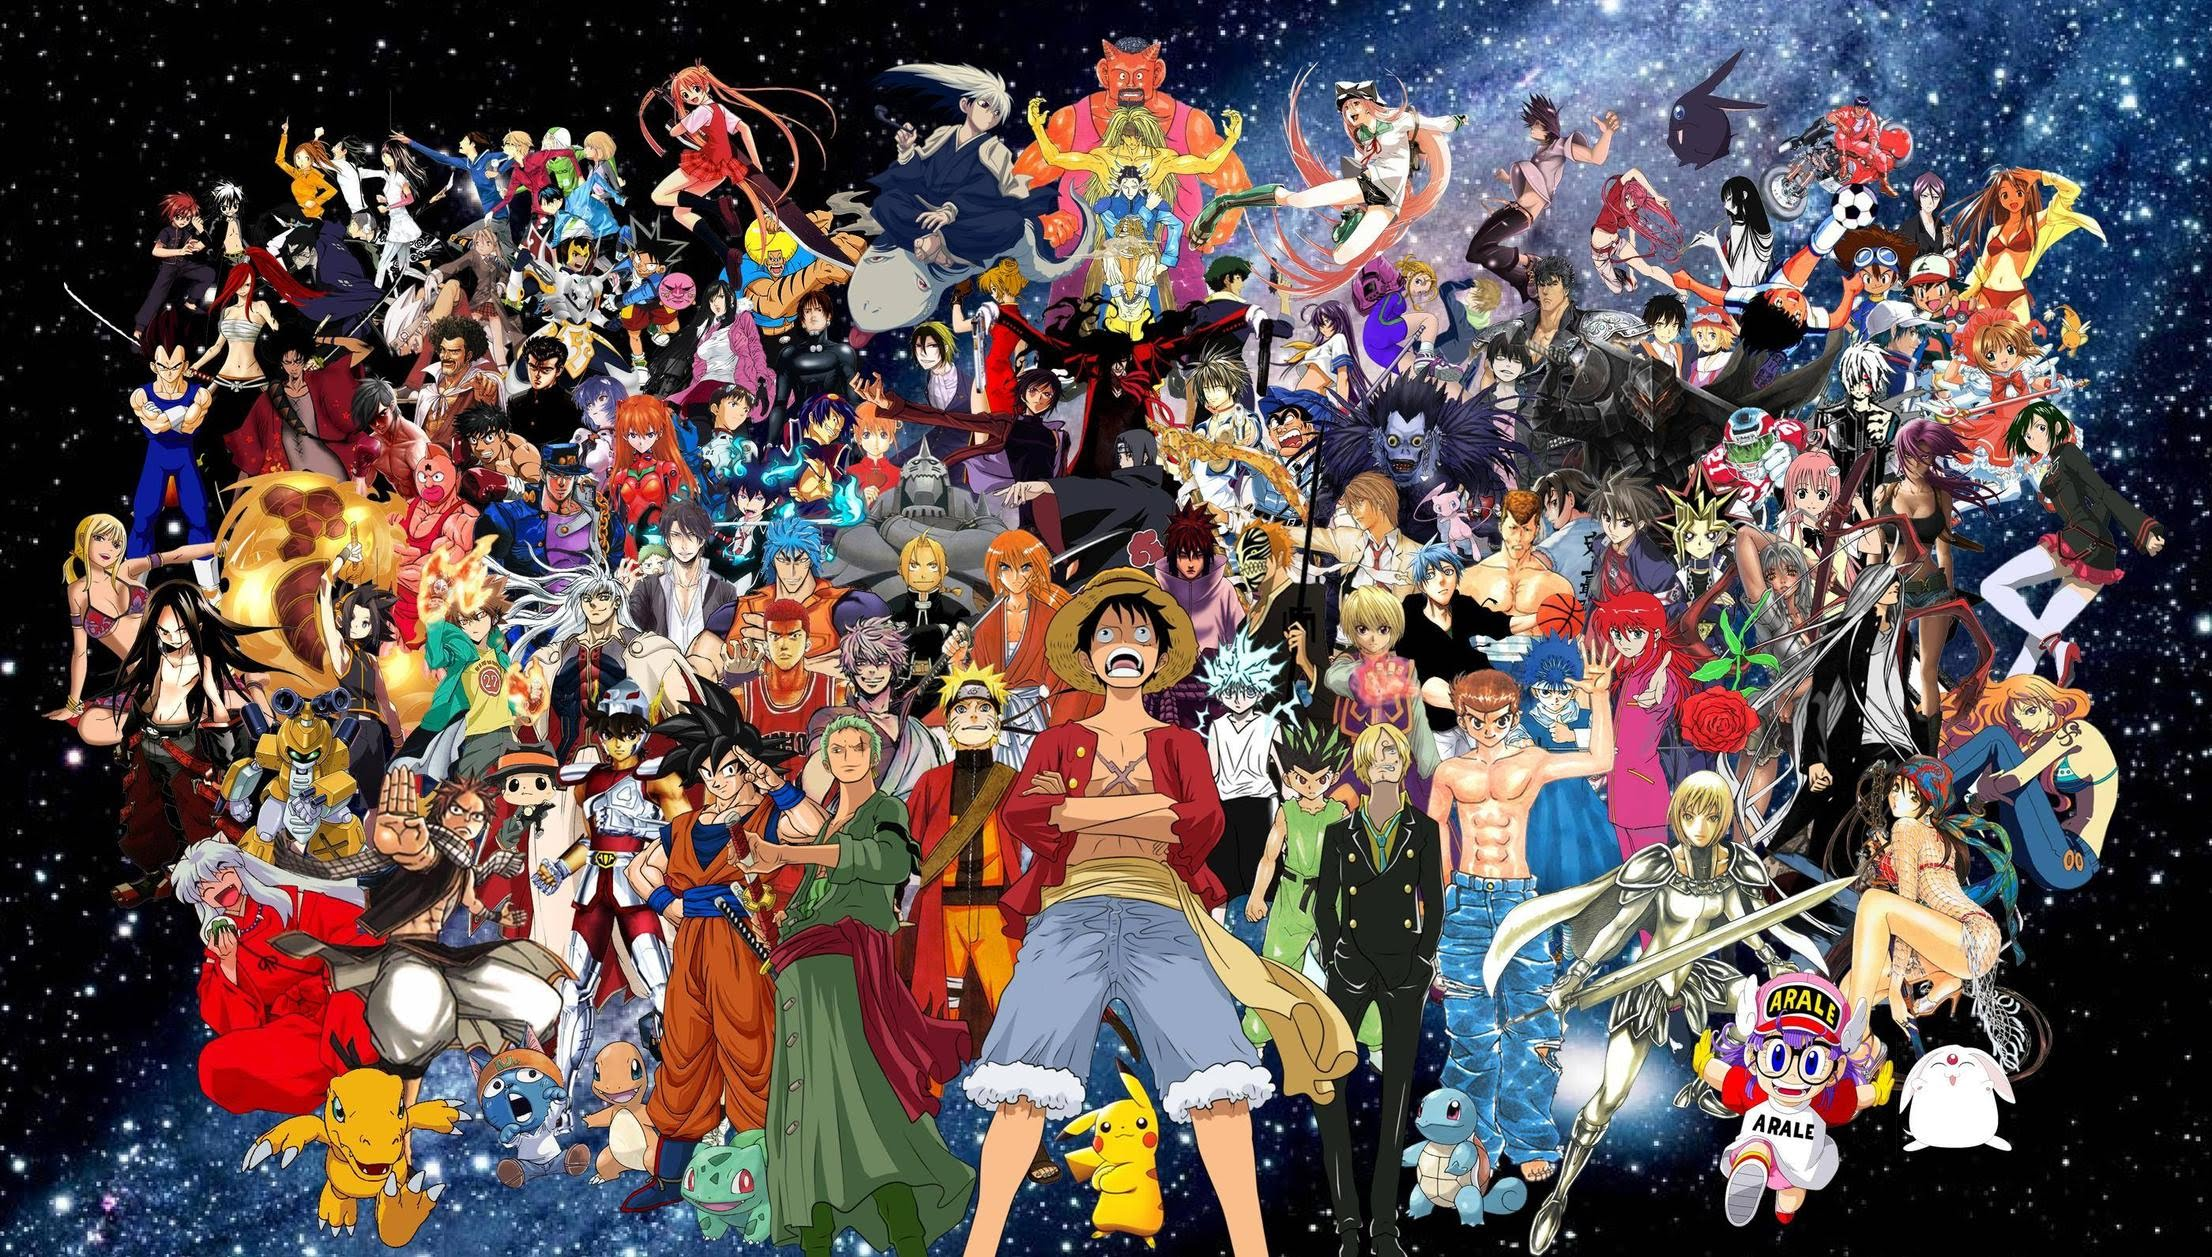

# Contents

* [Libraries](#Libraries)
* [Import Dataset](#ImportDataset)
* [Explore Data](#ExploreData)
* [Data Cleaning](#DataCleaning)

* [Univariate Analysis](#1)
    * [Genre](#2)
    * [Types](#3)
    * [Anime Rating](#4)
    * [User Rating](#5)
    
* [Bivariate Analysis](#6)
    * [Top 10 genre by members](#7)
    * [Average rating by type](#8)
    * [Member percentage by type](#9)
    * [Average rating by genre count](#10)
    * [Average members by episodes](#11)
    * [Average rating by episodes](#12)
    * [Average episodes per type](#13)
    * [Top 6 Entities](#14)
    * [Average Ratings for Top 6 Entities](#15)
    * [Number of Words by count](#16)
    * [Number of Words by Average Ratings](#17)

* [The Age of Recommender Systems](#18)
    * [Content Based Filtering](#19)
    * [Collaborative Filtering](#20)

* [Model Selection](#22)
* [Final Recommender](#23)

* [Conclusion](#21)

# Problem Statement 
***

1.Exploratory Data Analysis on Animes data  
2.Build a machine learning model for anime recommendation.

## Data Exploration
***

### Column Details of anime data

* anime_id - myanimelist.net's unique id identifying an anime.
* name - full name of anime.
* genre - comma separated list of genres for this anime.
* type - movie, TV, OVA, etc.
* episodes - how many episodes in this show. (1 if movie).
* rating - average rating out of 10 for this anime.
* members - number of community members that are in this anime's "group".

### Column Details of rating data

* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

### Libraries  <a id='another_cell'></a>

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import en_core_web_sm
import nltk
import string
import math
import re
import matplotlib.pyplot as plt
import pickle
import random
import itertools
from spacy import displacy
from scipy.sparse import csr_matrix
from collections import Counter
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from surprise import Reader, Dataset, SVD, SVDpp, NormalPredictor, KNNBaseline, KNNBasic
from surprise.model_selection import cross_validate

### Import Data <a id='ImportDataset'></a>

Import the data from a csv file.

In [36]:
anime_data = pd.read_csv(r"anime.csv")
rating_data = pd.read_csv(r"rating.csv")

### Explore Data <a id='ExploreData'></a>

In [37]:
anime_data.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

In [38]:
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Names of all columns 

In [39]:
anime_data.columns

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')

Shape of anime_data

In [40]:
anime_data.shape

(12294, 7)

Checking for null values in anime_data

In [41]:
anime_data.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

### Data Cleaning <a id='DataCleaning'></a>

Filling null ratings with 0

In [42]:
anime_data.rating.fillna(0,inplace=True)

In [43]:
#Checking for null values in anime_data
anime_data.isnull().sum()

anime_id     0
name         0
genre       62
type        25
episodes     0
rating       0
members      0
dtype: int64

Replacing missing genre with most watched genre

In [44]:
genre_count = dict()
anime_data1 = anime_data[anime_data['genre'].notnull()]
for i in anime_data1.genre:
    temp = i.split()
    for genre in temp:
        genre = genre.replace(",","")
        if genre_count.get(genre) == None:
            genre_count.setdefault(genre,1)
        else:
            genre_count.update({genre:genre_count.get(genre)+1})
            
for i,j in zip(genre_count,genre_count.values()):
    if j == max(genre_count.values()):
        mode_genre = i
        print(i + " " + str(j))
        
anime_data.genre.fillna(mode_genre,inplace=True)

Comedy 4645


Replacing missing types with mode of types

In [45]:
anime_data.type.fillna(anime_data.type.mode()[0],inplace=True)

Showing no null values are remained in anime_data

In [46]:
anime_data.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

Showing data types all attributes

In [47]:
anime_data.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

Episodes columns can not be negative. There are some rows having value as "Unknown"

In [48]:
for i,j in enumerate(list(anime_data['episodes'])):
    if j.isalpha():
        print(i," ",j)

74   Unknown
252   Unknown
615   Unknown
991   Unknown
1021   Unknown
1272   Unknown
1309   Unknown
1928   Unknown
1930   Unknown
1993   Unknown
2030   Unknown
2073   Unknown
2368   Unknown
2530   Unknown
2721   Unknown
2738   Unknown
2777   Unknown
2810   Unknown
2951   Unknown
3051   Unknown
3055   Unknown
3574   Unknown
4735   Unknown
4870   Unknown
4885   Unknown
4975   Unknown
5365   Unknown
5411   Unknown
5500   Unknown
5583   Unknown
5650   Unknown
5655   Unknown
5762   Unknown
5793   Unknown
5920   Unknown
5995   Unknown
6314   Unknown
6335   Unknown
6341   Unknown
6478   Unknown
6629   Unknown
6776   Unknown
6816   Unknown
7573   Unknown
7626   Unknown
7760   Unknown
7842   Unknown
7924   Unknown
8124   Unknown
8126   Unknown
8134   Unknown
8136   Unknown
8142   Unknown
8151   Unknown
8167   Unknown
8200   Unknown
8208   Unknown
8285   Unknown
8289   Unknown
8423   Unknown
8435   Unknown
8437   Unknown
8445   Unknown
8480   Unknown
8498   Unknown
8504   Unknown
8520   Unknown


Dropping animes which have episodes as "Unknown" and ratings < 3

In [49]:
anime_data[(anime_data['rating']<3)]

,anime_id,name,genre,type,episodes,rating,members
8051,5877,Abunai Sisters: Koko &amp; Mika,"Action, Comedy, Ecchi",OVA,10,2.95,1461
8052,16608,Shitcom,"Comedy, Romance",ONA,1,2.93,8126
8053,6953,Ningen Doubutsuen,Dementia,Movie,1,2.78,1893
8054,31634,Kokuhaku,Horror,ONA,1,2.67,816
8055,29949,Nami,Dementia,Movie,1,2.67,1817
...,...,...,...,...,...,...,...
12274,34492,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,Hentai,OVA,Unknown,0.00,392
12279,34491,Sagurare Otome The Animation,Hentai,OVA,1,0.00,79
12280,34312,Saimin Class,Hentai,OVA,Unknown,0.00,240
12282,34388,Shikkoku no Shaga The Animation,Hentai,OVA,Unknown,0.00,195


In [50]:
cond = anime_data[(anime_data['rating']<3) & (anime_data['episodes']=='Unknown')].index
anime_data.drop(cond,inplace=True)

In [51]:
cond = anime_data['episodes']=='Unknown'
anime_data.loc[cond,'episodes']=-1

In [52]:
len(anime_data[anime_data['episodes']=='Unknown'])

0

In [53]:
anime_data['episodes'] = anime_data['episodes'].astype(int)

Genre count of each anime

In [54]:
def count_genre(f):
    count_of_genre=[]
    f['genre']=f['genre'].astype(str)
    for genre in f['genre']:
        if genre!='NaN':
            count=len(genre.split(','))
            count_of_genre.append(count)
        else:
            count_of_genre.append(-1)
    return count_of_genre

anime_data['count_genre']=count_genre(anime_data)
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members,count_genre
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,4
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,7
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,7
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,2
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,7


Count of each genre count

In [55]:
anime_data['count_genre'].value_counts()

1     2824
2     2645
3     2572
4     1915
5     1243
6      586
7      226
8       73
9       40
10      11
11       2
13       1
Name: count_genre, dtype: int64

In [56]:
anime_data['popularity'] = anime_data['rating']*anime_data['members']

In [57]:
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members,count_genre,popularity
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,4,1879903.10
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,7,7349337.90
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,7,1056923.50
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,2,6176655.24
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,7,1385596.56


### For rating data

### Explore Data

In [58]:
rating_data.dtypes

user_id     int64
anime_id    int64
rating      int64
dtype: object

In [59]:
rating_data.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Names of all columns 

In [60]:
rating_data.columns

Index(['user_id', 'anime_id', 'rating'], dtype='object')

Shape of anime_data

In [61]:
rating_data.shape

(7813737, 3)

Checking for null values in rating_data

In [62]:
rating_data.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

***

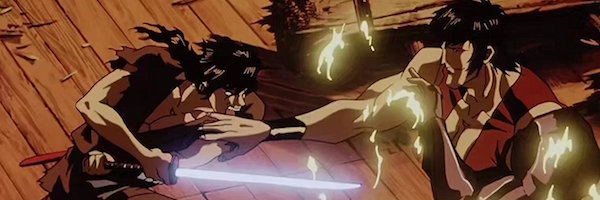

# Data Analysis
***
This section represent the Univariate and Bivariate analysis of the data

## Univariate Analysis <a id='1'></a>

Univariate analysis is the analysis of one variable. It's major purpose is to describe patterns in the data consisting of single variable.

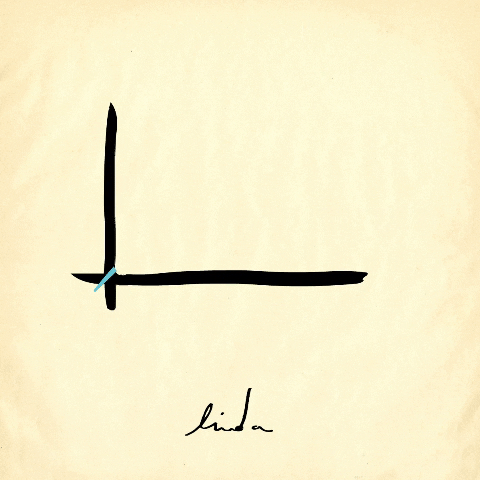

In [30]:
top10_genre=dict(sorted(genre_count.items(), key=lambda item: item[1],reverse=True)[0:10])
top10_genre

{'Comedy': 4645,
 'Action': 2845,
 'Adventure': 2348,
 'Fantasy': 2309,
 'Sci-Fi': 2070,
 'Drama': 2016,
 'Shounen': 1777,
 'Kids': 1609,
 'Romance': 1464,
 'School': 1220}

In [31]:
key_list = list(top10_genre.keys())
val_list = list(top10_genre.values())

#### Genre  <a id='2'></a>

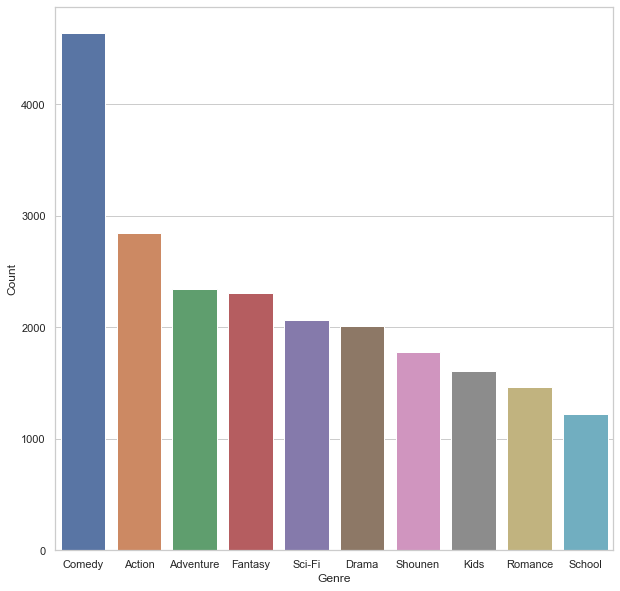

In [78]:
sns.barplot(x = key_list,y = val_list)
sns.set(rc={'figure.figsize':(20,5)}) 
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

* This chart gives information about top 10 anime genres by its count
* Comedy genre is most common genre

#### Types  <a id='3'></a>

A code indicating the type associated with the animes

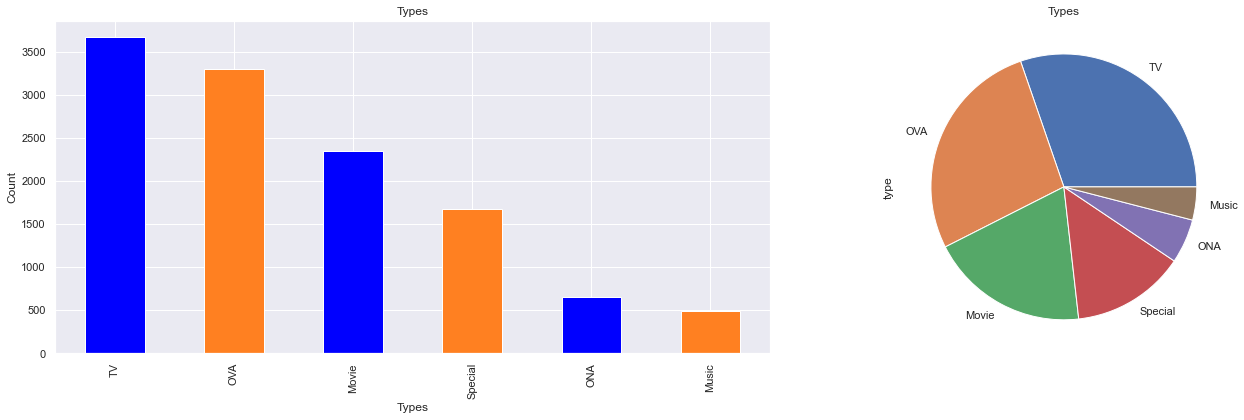

In [33]:
sns.color_palette("Paired")
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,6))
ax = anime_data['type'].value_counts().plot(kind='bar',title="Types",ax=axes[0],color = ('blue',(1, 0.5, 0.13)))
anime_data['type'].value_counts().plot(kind='pie',title="Types",ax=axes[1])
ax.set_ylabel("Count")
ax.set_xlabel("Types")
fig.tight_layout()

* This chart gives information about types of anime by its count
* TV is the most common type

#### Anime Rating  <a id='4'></a>

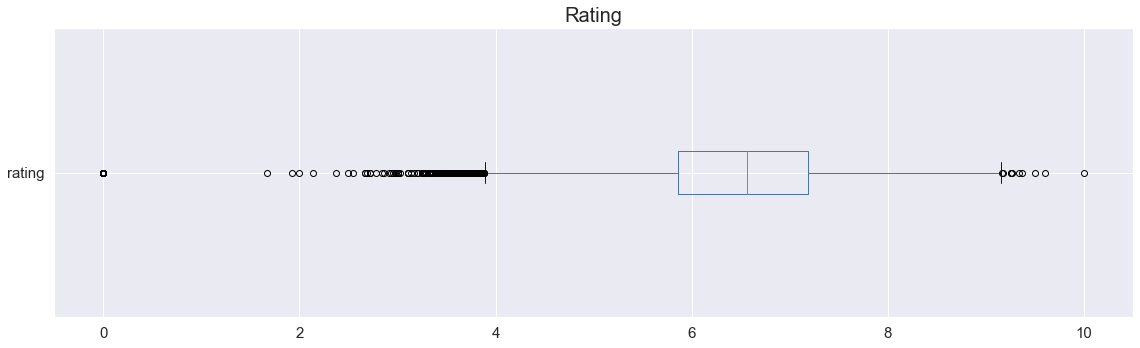

In [34]:
sns.color_palette("Paired")
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16,5))
box = anime_data['rating'].plot(kind='box',vert = False,fontsize = 15)
box.set_title('Rating',fontsize = 20)
fig.tight_layout()

* This chart shows that most of the rating lies above 6.5
* Outliers lies below 4 and above 9

#### User Rating  <a id='5'></a>

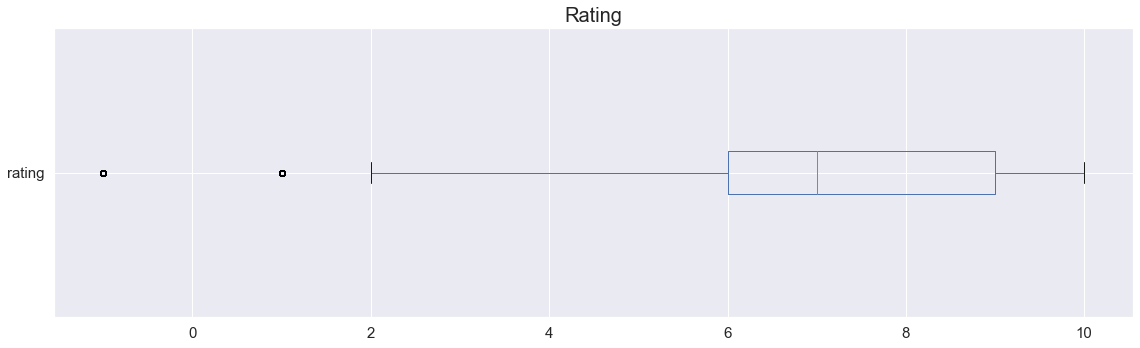

In [35]:
sns.color_palette("Paired")
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16,5))
box = rating_data['rating'].plot(kind='box',vert = False,fontsize = 15)
box.set_title('Rating',fontsize = 20)
fig.tight_layout()

* This chart shows that most of the rating lies above 6
* Outliers lies below 2

## Bivariate Analysis  <a id='6'></a>

Bivariate analysis is used to find out if there is a relationship between two sets of values. It usually involves the variables X and Y.

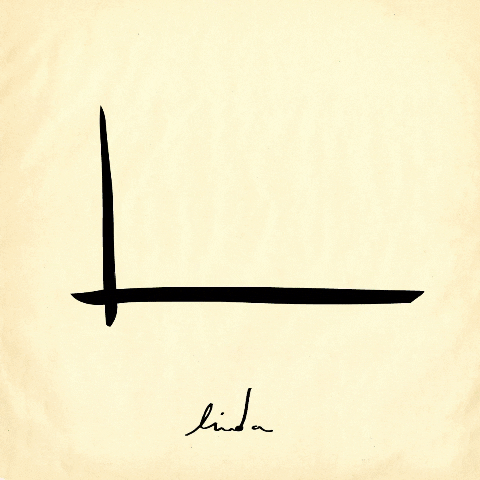

#### Top 10 genre by membre count.
Here we calculating members count per genre <a id='7'></a>

In [29]:
gen_mem = dict()
for genre in genre_count:
    for genre_list,member in zip(anime_data.genre,anime_data.members):
        if genre in genre_list:
            if gen_mem.get(genre) == None:
                gen_mem.setdefault(genre,member)
            else:
                gen_mem.update({genre:gen_mem.get(genre)+member})

In [32]:
top10_gen_mem=dict(sorted(gen_mem.items(), key=lambda item: item[1],reverse=True)[0:10])

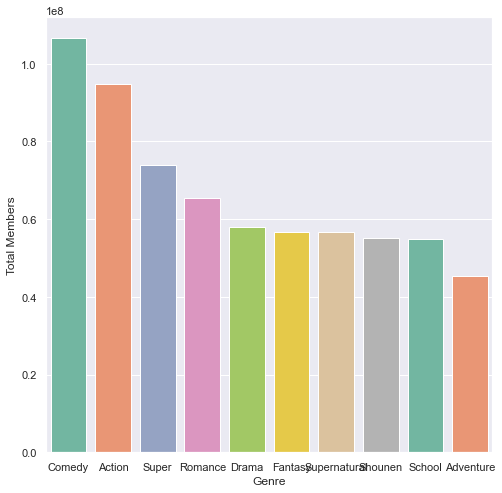

In [33]:
sns.color_palette("Paired")
sns.barplot(x = list(top10_gen_mem.keys()),y = list(top10_gen_mem.values()),palette="Set2")
sns.set(rc={'figure.figsize':(8,8)}) 
plt.xlabel("Genre")
plt.ylabel("Total Members")

plt.show()

* This chart shows that user prefers watching comedy and action genres

#### Average rating by type  <a id='8'></a>

In [39]:
type_rating = anime_data.groupby("type")["rating"].mean()
type_rating

type
Movie      6.188733
Music      5.588996
ONA        5.622095
OVA        6.348166
Special    6.504039
TV         6.890675
Name: rating, dtype: float64

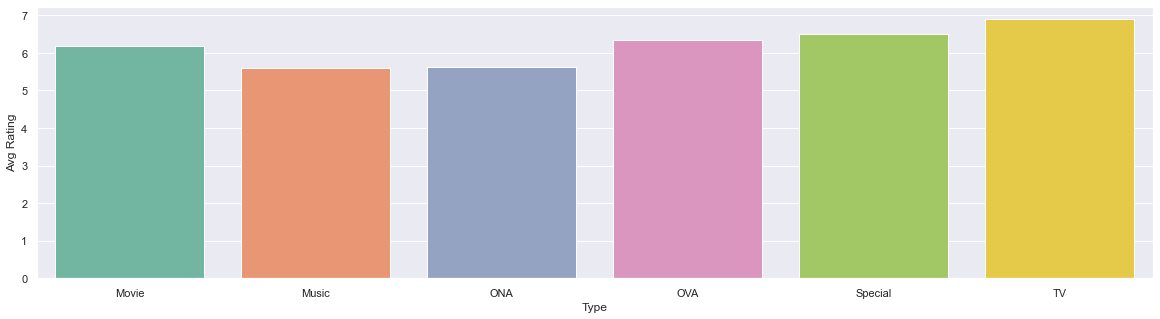

In [81]:
sns.color_palette("Paired")
sns.barplot(x = type_rating.index ,y = type_rating.values,palette="Set2")
sns.set(rc={'figure.figsize':(12,6)}) 
plt.xlabel("Type")
plt.ylabel("Avg Rating")
plt.show()

* This chart shows that the rating doesn't depend on type of the anime 

#### Member percentage by type  <a id='9'></a>

In [41]:
total_mem = sum(anime_data.members)
type_mem = anime_data.groupby("type")["members"].agg(Member_percentage=("members",lambda x : (sum(x)/total_mem)*100))

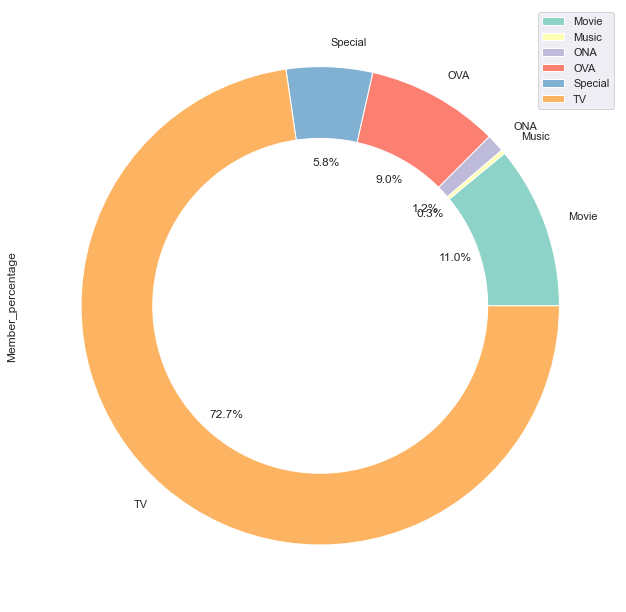

In [42]:
sns.color_palette("Paired")
sns.set(rc={'figure.figsize':(15,11)},palette="Set3")
type_mem.plot.pie(y="Member_percentage",autopct="%.1f%%")

circle = plt.Circle(xy=(0,0), radius=0.70, facecolor='white')
plt.gca().add_artist(circle)
plt.show()

* This chart shows that most of the users prefers to watch TV type

#### Average rating by genre count  <a id='10'></a>

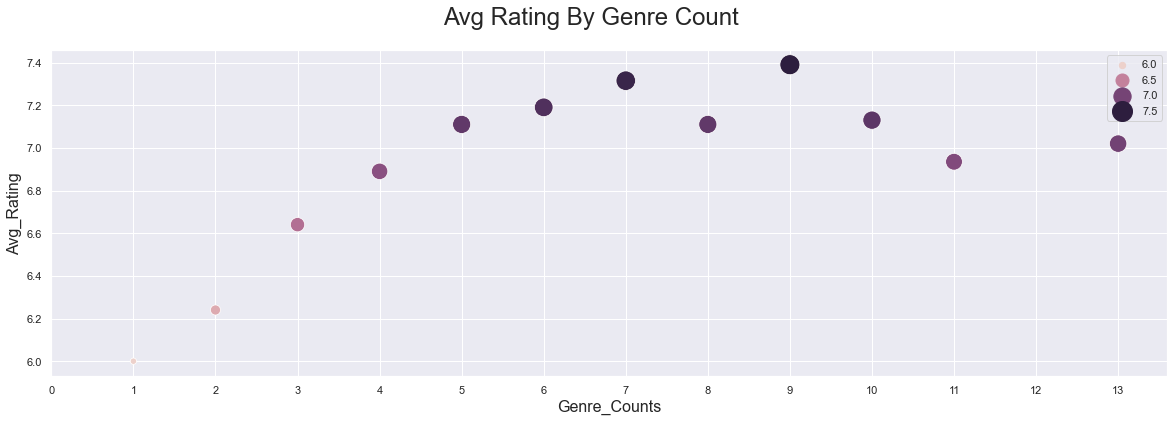

In [43]:
grpby_cnt_gnr= anime_data.groupby(['count_genre']).median()
grpby_cnt_gnr=grpby_cnt_gnr.rating
plt.figure(figsize = (20,6))
sns.color_palette("Paired")
ax=sns.scatterplot(x=grpby_cnt_gnr.index, y=grpby_cnt_gnr.values, hue=grpby_cnt_gnr.values, size=grpby_cnt_gnr.values,sizes=(40, 400))
ax.set_xticks(range(0,14))
plt.xlabel("Genre_Counts", size = 16)
plt.ylabel("Avg_Rating", size = 16)
plt.suptitle('Avg Rating By Genre Count', size = 24)
plt.show()

* This chart shows that most of the users prefers watching animes having genre counts in the range of 5-11

#### Average members by episodes <a id='11'></a>

In [44]:
ep_mem = anime_data.groupby(['episodes'],sort = True)['members'].mean()

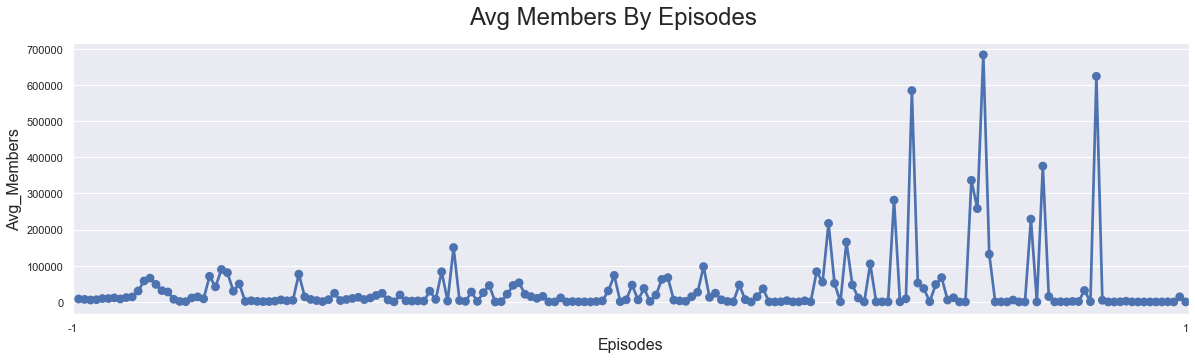

In [85]:
plt.figure(figsize = (20,5))
sns.color_palette("Paired")
ax = sns.pointplot(x=ep_mem.index, y=ep_mem.values)
ax.set_xticks(range(-1,187,187))
plt.xlabel("Episodes", size = 16)
plt.ylabel("Avg_Members", size = 16)
plt.suptitle("Avg Members By Episodes", size = 24)
plt.show()

* Members prefers watching animes with more number of episodes

#### Average rating by episodes <a id='12'></a>

In [46]:
ep_rat = anime_data.groupby(['episodes'],sort = True)['rating'].mean()

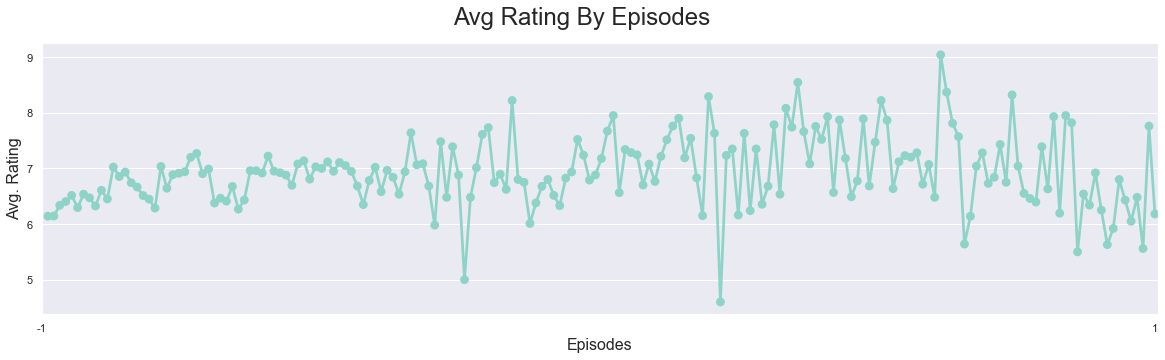

In [47]:
plt.figure(figsize = (20,5))
sns.color_palette("Paired")
ax = sns.pointplot(x=ep_rat.index, y=ep_rat.values)
ax.set_xticks(range(-1,187,187))
plt.xlabel("Episodes", size = 16)
plt.ylabel("Avg. Rating", size = 16)
plt.suptitle("Avg Rating By Episodes", size = 24)
plt.show()

* This shows rating does not depend on number of episodes watched

#### Average episodes per type <a id='13'></a>

In [48]:
type_ep = anime_data.groupby(['type'],sort = True)['episodes'].median()

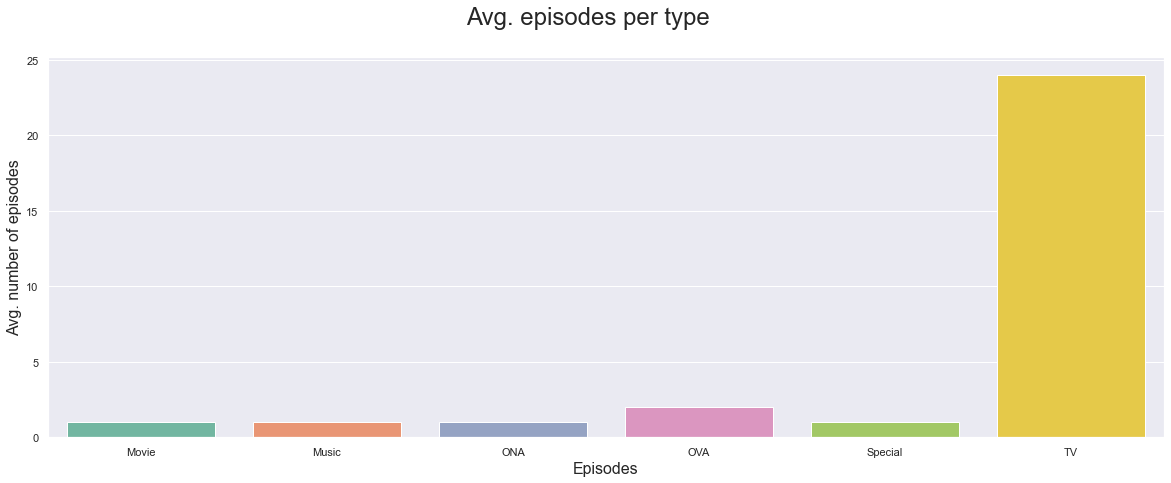

In [49]:
plt.figure(figsize = (20,7))
sns.color_palette("Paired")
ax = sns.barplot(x=type_ep.index, y=type_ep.values,palette="Set2")
plt.xlabel("Episodes", size = 16)
plt.ylabel("Avg. number of episodes", size = 16)
plt.suptitle("Avg. episodes per type", size = 24)
plt.show()

* TV type of animes have the most number of episodes

In [34]:
#Analysing anime names

In [92]:

nlp = en_core_web_sm.load()
#is a small English pipeline trained on written web text (blogs, news, comments), that includes vocabulary, vectors, syntax and entities.
name_list=list(anime_data['name'])

C:\Users\91828\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [93]:
#here each word of the anime name is associated with their matching entities, this list is stored in entity list
entity_lis=[]
for i in name_list:
    doc = nlp(i)
    entity_lis.append([(X.text, X.label_) for X in doc.ents])
#X.label_ denotes  the entity name, X.text denotes the word
entity_lis

[[],
 [('Brotherhood', 'ORG')],
 [('Gintama°', 'PERSON')],
 [],
 [],
 [('Haikyuu', 'PERSON'),
  ('Karasuno Koukou VS', 'ORG'),
  ('Gakuen Koukou', 'PERSON')],
 [('Hunter x Hunter', 'PERSON'), ('2011', 'DATE')],
 [('Ginga Eiyuu Densetsu', 'PERSON')],
 [('Kanketsu', 'PERSON')],
 [],
 [('Clannad', 'GPE')],
 [('Koe no Katachi', 'PERSON')],
 [],
 [('Geass', 'PERSON'), ('Hangyaku', 'PERSON'), ('Lelouch R2', 'PERSON')],
 [('Haikyuu', 'PERSON'), ('Second', 'ORDINAL')],
 [],
 [('Shigatsu', 'ORG'), ('Kimi', 'PERSON')],
 [('Mushishi Zoku Shou', 'PERSON')],
 [('Ookami Kodomo no Ame', 'PERSON')],
 [('Geass', 'PERSON'), ('Hangyaku', 'PERSON')],
 [('Hajime', 'ORG')],
 [('Rurouni Kenshin', 'PERSON'),
  ('Meiji Kenkaku Romantan - Tsuioku', 'PERSON')],
 [],
 [('One', 'CARDINAL')],
 [],
 [('Suzumiya Haruhi', 'PERSON')],
 [('Second', 'ORDINAL')],
 [('Mushishi Zoku Shou', 'PERSON')],
 [('Mushishi', 'ORG')],
 [('Tengen', 'ORG'), ('Gurren Lagann', 'PERSON')],
 [('Onizuka', 'PERSON')],
 [],
 [('Hajime', 'ORG'

In [94]:
#here all the words without any entities are stored onto non_entity list
#all uniques entities are stored in uni_entities set
uni_entities=set()
non_entity=[]
count=0
for i,j in enumerate(entity_lis):
    if len(j)==0:#checking if words are associated with entities, if 0 then no mathing entities was found..and therbey stored in non entity list
        count+=1
        non_entity.append(i)
    else:
        for num in j:
            uni_entities.add(num[1])
print("The number of animes with no entities is : "+str(count))

The number of animes with no entities is : 4226


In [95]:
# a dictionary with keys as uni_entities in created
names_row_dict={}
for i in uni_entities:
    names_row_dict[i]=[]
names_row_dict['COMB']=[]#comb keys represents anime names which have more than one entities

In [96]:
#classifying anime based on their entities
for i,j in enumerate(entity_lis):
    if len(j)==1:#if only one entity is there
        for num in j:
            if num[1] in names_row_dict.keys():
                names_row_dict[num[1]].append(i)
    elif len(j)>1:#if anime names contain more than one entity
        names_row_dict['COMB'].append(i)
        

In [97]:
names_row_dict['NO_ENT']=non_entity #all anime names without any entity goes here 

In [99]:
#finding the number of occurences
length_names={}
for i in names_row_dict.keys():
    length_names[i]=len(names_row_dict[i])
length_names

{'TIME': 5,
 'FAC': 24,
 'PRODUCT': 7,
 'GPE': 477,
 'NORP': 72,
 'EVENT': 10,
 'ORG': 988,
 'LOC': 12,
 'LAW': 8,
 'DATE': 92,
 'ORDINAL': 10,
 'PERSON': 3669,
 'PERCENT': 8,
 'QUANTITY': 0,
 'LANGUAGE': 1,
 'WORK_OF_ART': 7,
 'CARDINAL': 241,
 'MONEY': 1,
 'COMB': 2280,
 'NO_ENT': 4226}

In [100]:
#the top 6 occuring entities
length_names_odr=dict(sorted(length_names.items(), key=lambda item: item[1],reverse=True))
top_names=dict(sorted(length_names.items(), key=lambda item: item[1],reverse=True)[0:6])
top_names

{'NO_ENT': 4226,
 'PERSON': 3669,
 'COMB': 2280,
 'ORG': 988,
 'GPE': 477,
 'CARDINAL': 241}

In [102]:
#splitting the dictionary into lists
df1=list(top_names.keys())
df2=list(top_names.values())

In [107]:
nr_list=[]
for i,j in enumerate(names_row_dict):
    if j in top_names.keys():
        nr_list.append(j)

In [109]:
for i,j in enumerate(top_names):
    print(j)
    nr_list[i]=anime_data.iloc[names_row_dict[j],[1,5]]

NO_ENT
PERSON
COMB
ORG
GPE
CARDINAL


#### Top 6 Entities <a id='14'></a> 

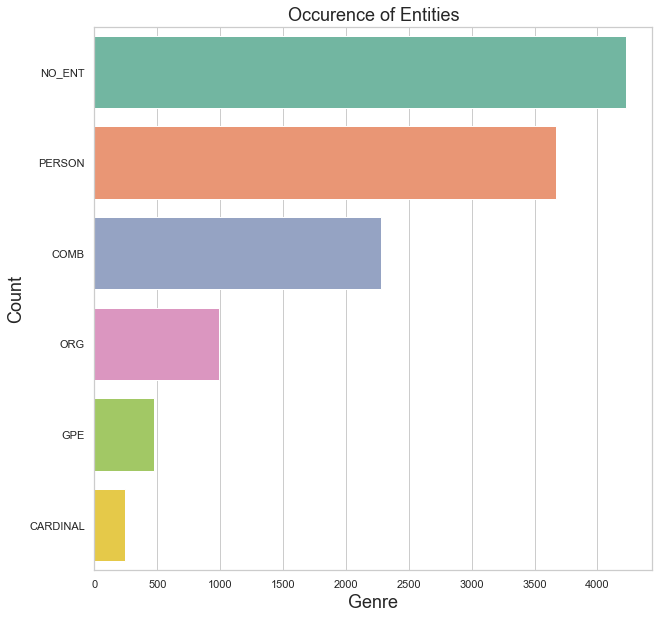

In [110]:
# who v/s fare barplot 
sns.color_palette("Paired")
y=sns.barplot(x=df2, y = df1,palette="Set2")
ax=y
sns.set(rc={'figure.figsize':(10,10)}) 
plt.xlabel("Genre",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Occurence of Entities",fontsize=18 )
sns.set_style("whitegrid")

 * This chart shows top 6 entities of anime names

#### Average Ratings for Top 6 Entities <a id='15'></a>

In [111]:
avg_list=[]
for i,j in enumerate(top_names):
    average=nr_list[i].rating.sum()/top_names[j]
    avg_list.append(average)

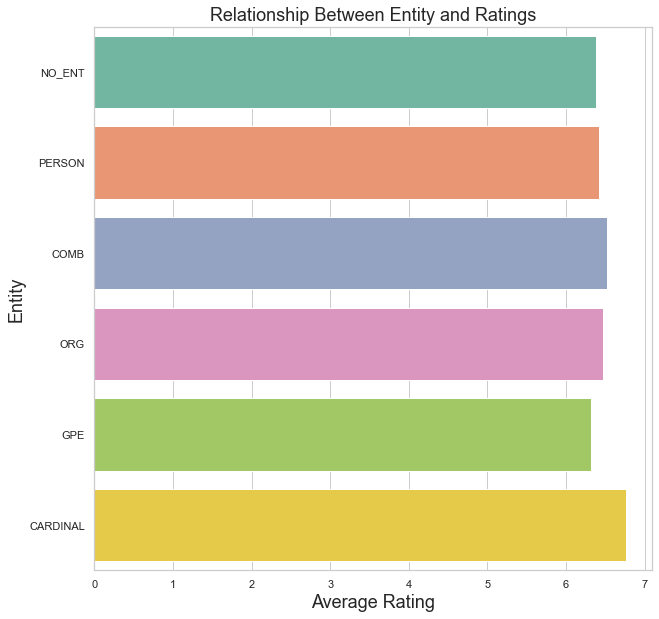

In [112]:
# who v/s fare barplot 
sns.color_palette("Paired")
y=sns.barplot(x=avg_list, y = df1,palette="Set2")
ax=y
sns.set(rc={'figure.figsize':(10,10)}) 
plt.xlabel("Average Rating",fontsize=18)
plt.ylabel("Entity",fontsize=18)
plt.title("Relationship Between Entity and Ratings",fontsize=18 )
sns.set_style("whitegrid")

* The naming convention of animes doesnt have any relation to the ratings

Finding a relation between number of words and rating

In [56]:
dummy=anime_data.iloc[:,[1,5]]

dummy.drop_duplicates(subset='name',inplace=True)

<ipython-input-56-037e10a6d4ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy.drop_duplicates(subset='name',inplace=True)


Finding the number of words of each anime 

In [57]:
nu_of_words={}
punc = '''.'''
for i in dummy.name:
    words = nltk.word_tokenize(i)
    nu_of_words[i]=len(words)

    
li=list(nu_of_words.values())
dummy['word_ln']=li

<ipython-input-57-e55db4c4a423>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy['word_ln']=li


#### Average rating grouped by the number of words <a id='16'></a>

In [58]:
top_words=[]
averages=[]
count=[]
cond=dummy['word_ln'].value_counts()
for i in range(1,23):
    top_words.append(i)
    count.append(cond[i])
style=dummy.groupby('word_ln')
for i in top_words:
    averages.append(style.get_group(i)['rating'].sum()/cond[i])

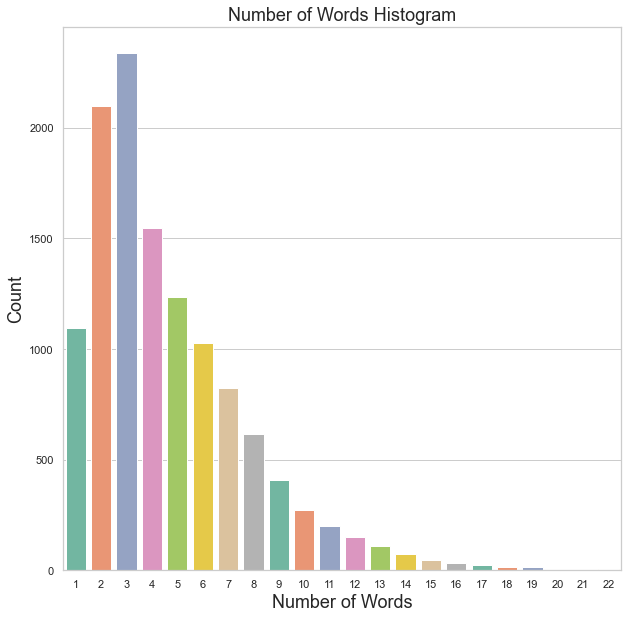

In [59]:
sns.color_palette("Paired")
y=sns.barplot(x=top_words, y =count ,palette="Set2")
ax=y
sns.set(rc={'figure.figsize':(10,10)}) 
plt.xlabel("Number of Words",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Number of Words Histogram",fontsize=18 )
sns.set_style("whitegrid")

* Most of the anime names have wordcounts in the range of 2-4

#### Number of Words vs Average Ratings  <a id='17'></a>

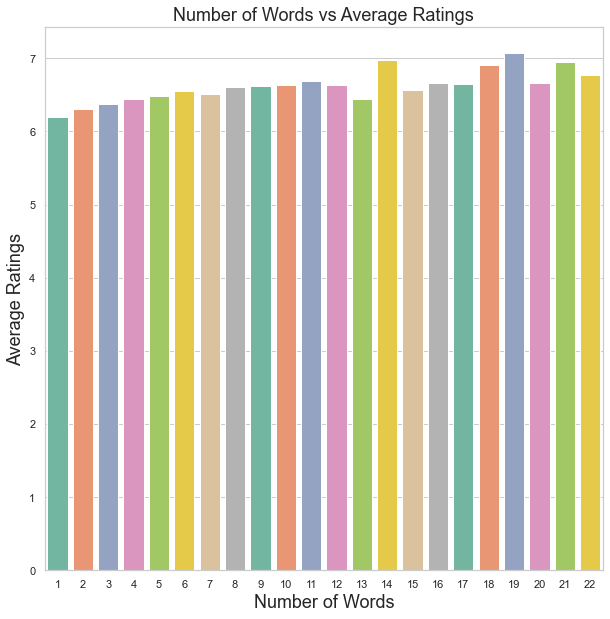

In [60]:
sns.color_palette("Paired")
y=sns.barplot(x=top_words, y =averages ,palette="Set2")
ax=y
sns.set(rc={'figure.figsize':(10,10)}) 
plt.xlabel("Number of Words",fontsize=18)
plt.ylabel("Average Ratings",fontsize=18)
plt.title("Number of Words vs Average Ratings",fontsize=18 )
sns.set_style("whitegrid")

* This shows the ratings doesn't depend on number of words in the anime name

# The Age of Recommender Systems <a id='18'></a>
***

The rapid growth of data collection has led to a new era of information. Data is being used to create more efficient systems and this is where Recommendation Systems come into play. Recommendation Systems are a type of information filtering systems as they improve the quality of search results and provides items that are more relevant to the search item or are realted to the search history of the user.






They are used to predict the rating or preference that a user would give to an item. Almost every major tech company has applied them in some form or the other: Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on autoplay, and Facebook uses it to recommend pages to like and people to follow. Moreover, companies like Netflix and Spotify depend highly on the effectiveness of their recommendation engines for their business and sucees.

In this kernel we'll be building a baseline Anime Recommendation System using Anime Dataset

There are basically two types of recommender systems:-

* **Content Based Filtering-** They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.
 
   
* **Collaborative Filtering-** This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.



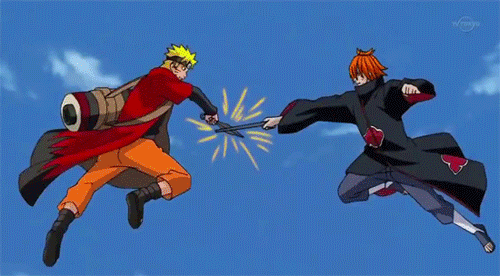

## Content Based Filtering  <a id='19'></a>

In this recommender system the content of the animes (name, genre, type etc.) is used to find its similarity with other animes. Then the animes that are most likely to be similar are recommended.

In [61]:
cdf=anime_data.copy()
dff=anime_data.copy()
dff.head()

,anime_id,name,genre,type,episodes,rating,members,count_genre,popularity
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,4,1879903.10
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,7,7349337.90
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,7,1056923.50
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,2,6176655.24
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,7,1385596.56


In [62]:
dff = dff[['name','genre','type']]
dff.head()

,name,genre,type
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV
3,Steins;Gate,"Sci-Fi, Thriller",TV
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV


In [63]:
dff['genre']= dff['genre'].map(lambda x: x.lower().split(','))
dff['title']= dff['name'].map(lambda x: x.lower().replace(" ",""))
dff['type']= dff['type'].map(lambda x: x.lower())

dff.set_index('title',inplace=True)
dff.head()

,name,genre,type
title,,,
kiminonawa.,Kimi no Na wa.,"[drama, romance, school, supernatural]",movie
fullmetalalchemist:brotherhood,Fullmetal Alchemist: Brotherhood,"[action, adventure, drama, fantasy, magic,...",tv
gintama°,Gintama°,"[action, comedy, historical, parody, samur...",tv
steins;gate,Steins;Gate,"[sci-fi, thriller]",tv
gintama&#039;,Gintama&#039;,"[action, comedy, historical, parody, samur...",tv


In [64]:
#initialising the new column
dff['bag_of_words'] = ''
columns = dff.columns
for index, row in dff.iterrows():
    words = ''
    for col in columns:
        words = words + ' '.join(row[col])+ ' '
    row['bag_of_words'] = words
    
dff.head()

,name,genre,type,bag_of_words
title,,,,
kiminonawa.,Kimi no Na wa.,"[drama, romance, school, supernatural]",movie,K i m i n o N a w a . drama romance sc...
fullmetalalchemist:brotherhood,Fullmetal Alchemist: Brotherhood,"[action, adventure, drama, fantasy, magic,...",tv,F u l l m e t a l A l c h e m i s t : B r ...
gintama°,Gintama°,"[action, comedy, historical, parody, samur...",tv,G i n t a m a ° action comedy historical pa...
steins;gate,Steins;Gate,"[sci-fi, thriller]",tv,S t e i n s ; G a t e sci-fi thriller t v
gintama&#039;,Gintama&#039;,"[action, comedy, historical, parody, samur...",tv,G i n t a m a & # 0 3 9 ; action comedy hist...


In [65]:
#instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(dff['bag_of_words'])

#creating a series for the anime names so they are associated to an ordered numerical
#lis will used to match the indexes
indices = pd.Series(dff.index)
indices[:5]
#print(count_matrix)

0                       kiminonawa.
1    fullmetalalchemist:brotherhood
2                          gintama°
3                       steins;gate
4                     gintama&#039;
Name: title, dtype: object

In [66]:
cosine_sim = cosine_similarity(count_matrix,count_matrix)
cosine_sim

array([[1.        , 0.18898224, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18898224, 1.        , 0.26726124, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.26726124, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [67]:
def content_based_recommendation(name,cosine_sim = cosine_sim):
    name1 = name.lower().replace(" ","")
    recommended_anime = []
    
    #getting the index of the anime that matches the name
    idx = indices[indices == name1].index[0]
    
    #creating a series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    
    #getting the indexes of the 10 most similar animes
    top10_indexes = list(score_series.iloc[1:11].index)
    
    #populating the list with the names of the best 10 matching animes
    for i in top10_indexes :
        recommended_anime.append(list(dff.name)[i])
    
    return recommended_anime

In [68]:
content_based_recommendation('naRuto')

['Naruto Shippuuden: Sunny Side Battle',
 'Naruto',
 'Naruto: Shippuuden Movie 4 - The Lost Tower',
 'Boruto: Naruto the Movie',
 'Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!',
 'Naruto x UT',
 'Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono',
 'Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi',
 'Kyutai Panic Adventure!',
 'Dragon Ball Z Movie 11: Super Senshi Gekiha!! Katsu no wa Ore da']

## Collaborative Filtering  <a id='20'></a>

Sampling training data

In [69]:
ls1=list(rating_data.groupby('user_id')['rating'].sum())
ls=list(rating_data.groupby('user_id').count()['anime_id'])
avg_usr_rat_lst=[]
for i,j in zip(ls1,ls):
    av=i/j
    avg_usr_rat_lst.append(av)

In [70]:
#creating a dataframe with user_id and average ratings of each user

dic={'avg_rating':avg_usr_rat_lst,'user_id':range(1,73516)}
avg_tab=pd.DataFrame(dic)
avg_tab

,avg_rating,user_id
0,-0.712418,1
1,2.666667,2
2,7.382979,3
3,-1.000000,4
4,4.263383,5
...,...,...
73510,7.846154,73511
73511,7.515152,73512
73512,10.000000,73513
73513,7.719388,73514


In [71]:
#groups = avg_tab.groupby(['user_id', pd.cut(avg_tab.avg_rating, bins=100)])
#calc_table=groups.size().unstack()
#calc_table

In [86]:
calc_table = pd.read_csv(r'calc_table_bin100.csv')

##### To find the probabilty distribution of each bin and the number of users from each bin

In [87]:
#the counts of users in each bin is stored in cnt_bin_ls
cnt_bin_ls=list(np.histogram(avg_usr_rat_lst,bins=100)[0])
#the propertionof users in each bin is stored in avg_bin_ls, which is nothing but the probability 
avg_bin_ls=[]
for i in cnt_bin_ls:
    avg_bin_ls.append(i/sum(cnt_bin_ls))

In [88]:
len(avg_bin_ls)

100

In [89]:
#here the probabilty of the count is found and this is then normalised into a total of 1000 users
#in this case we are taking the total number of 1000 users for training 
#the final counts of number of users taken from each bin is stored in bin_cnt_fin
no_train_users=1000
ls_mul=res_list = [avg_bin_ls[i] * cnt_bin_ls[i] for i in range(len(avg_bin_ls))]
bin_cnt_fin=res=[int(ls_mul[i] * no_train_users/sum(ls_mul)) for i in range(len(ls_mul))]
for i,j in enumerate(bin_cnt_fin):
    if j==0:
        bin_cnt_fin[i]=1


##### Using the final bin cnt list to create train data 

In [90]:
final_usrid_ls=[]
for i,j in enumerate(calc_table.columns):
    ls=list(calc_table[calc_table[j]==1].index)
    final_usrid_ls.append(random.sample(ls,bin_cnt_fin[i]))
final_usrid_ls=list(itertools.chain(*final_usrid_ls))
len(final_usrid_ls)

1025

In [91]:
# the final data fram with user id in final_usrid_ls is created
rating_new=rating_data.copy()
# index set to user id
rating_new.set_index('user_id', inplace=True) 
rating_new1=rating_new[['anime_id','rating']].copy()
final_train_data=rating_new1.loc[final_usrid_ls].copy()
final_train_data=final_train_data.reset_index()
final_train_data

,user_id,anime_id,rating
0,6115,1,9
1,6115,20,8
2,6115,24,10
3,6115,27,8
4,6115,64,8
...,...,...,...
102878,54096,20,7
102879,54096,45,-1
102880,54096,121,8
102881,54096,223,8


In [ ]:
#final_train_data.to_csv(r'final_train_data_bin100.csv',header=True,index=False)

In [63]:
final_train_data=pd.read_csv("final_train_data.csv")

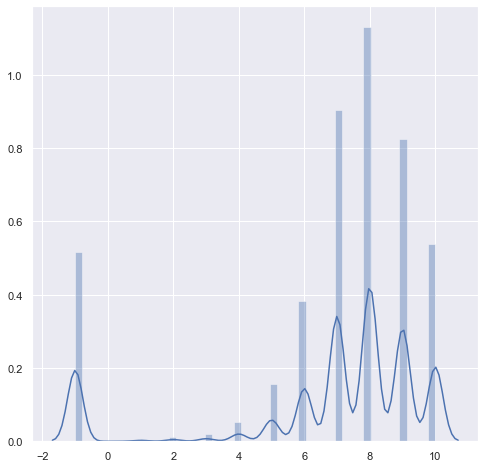

In [64]:
sns.distplot(list(final_train_data['rating']))

#### Model Selection  <a id='22'></a>

In [116]:
reader = Reader(rating_scale = (0,10))
data = Dataset.load_from_df(final_train_data[['user_id', 'anime_id', 'rating']], reader)

benchmark = []
Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), NormalPredictor(), KNNBaseline(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

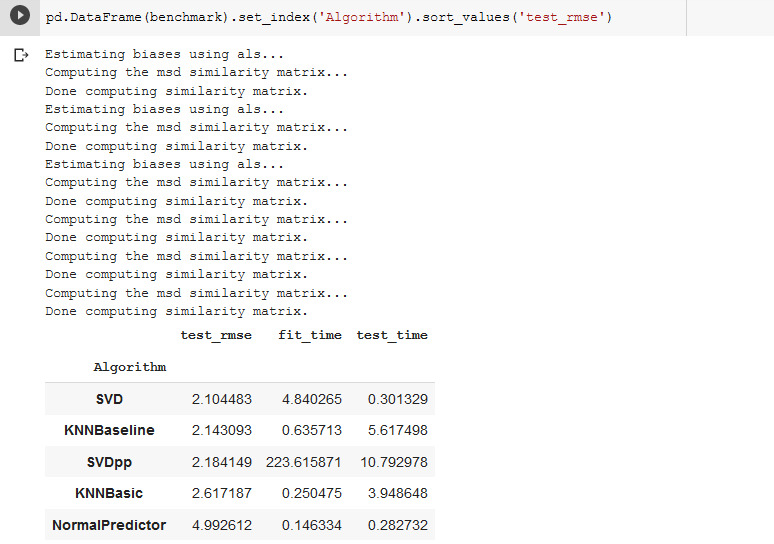

SVD

In [65]:
df = anime_data.copy()

In [66]:
reader = Reader(rating_scale = (0,10))

In [96]:
#data = Dataset.load_from_df(rating_data[['user_id', 'anime_id', 'rating']][0:1000000], reader)

In [97]:
#svd = SVD()
#cross_validate(svd, data, measures=['RMSE', 'MAE'],cv = 5)

In [98]:
#svd.fit(data.build_full_trainset())

In [99]:
#pickle.dump(svd,open('svd_algo','wb'))

In [67]:
svd = pickle.load(open('svd_algo','rb'))

In [68]:
def svd_recommend(user_id):
    user_anime_ids = rating_data.loc[rating_data['user_id'] == user_id ,'anime_id']
    user = anime_data[['anime_id','name']].copy()
    user = user.reset_index()
    user = user[~user['anime_id'].isin(user_anime_ids)]
    user['Estimate_Score'] = user['anime_id'].apply(lambda x: svd.predict(user_id, x).est)
    user = user.drop('index', axis = 1)
    user = user.sort_values('Estimate_Score', ascending=False)
    return user.head(10)

In [69]:
svd_recommend(13)

,anime_id,name,Estimate_Score
11333,11349,Soredemo Tsuma wo Aishiteru,3.241924
7,820,Ginga Eiyuu Densetsu,2.971613
5182,3875,Mahoutsukai Sally 2,2.970981
1579,399,Seikai no Senki Special,2.476800
4295,1742,Souryuuden,2.319930
1008,2724,Daicon Opening Animations,2.288752
11523,9006,Rei Zero,2.213272
2099,17901,All Alone With You,2.193074
11047,6465,Kangoku Senkan,2.053480
1903,6299,Maria-sama ga Miteru 4th Specials,2.050167


#### Final Recommender <a id='23'></a>

In [70]:
users = rating_data["user_id"].unique()
users

array([    1,     2,     3, ..., 73514, 73515, 73516], dtype=int64)

In [71]:
def valid_user_rating(user_id):
    user_rat = rating_data.loc[rating_data['user_id']==user_id]
    total_len = len(user_rat)
    no_rating_len = len(user_rat.loc[user_rat['rating'] == -1])
    if ((no_rating_len/total_len) >= 0.90):
        return False
    return True

In [72]:
def content_recommend(user_id):
    user_anime_ids = rating_data.loc[rating_data['user_id'] == user_id ,'anime_id']
    anime_data1 = anime_data[['anime_id','name','popularity']].copy()
    anime_data1 = anime_data1[anime_data1['anime_id'].isin(user_anime_ids)]
    user_anime = anime_data1.sort_values(by = ['popularity'],ascending=False)
    return content_based_recommendation(user_anime.iloc[0]['name'])

In [73]:
def show_popular():
    top_10_popular = anime_data.sort_values(by = 'popularity',ascending=False)[0:10]
    return top_10_popular['name']
show_popular()

40                           Death Note
86                   Shingeki no Kyojin
1      Fullmetal Alchemist: Brotherhood
804                    Sword Art Online
19      Code Geass: Hangyaku no Lelouch
3                           Steins;Gate
159                        Angel Beats!
131                           Toradora!
841                              Naruto
445                    Mirai Nikki (TV)
Name: name, dtype: object

In [75]:
def recommend(user_id = None):
    if user_id in users:
        if valid_user_rating(user_id):
            print("Using Colabrative Filtering (SVD)")
            return svd_recommend(user_id)
        else:
            print("Using Content Based")
            return content_recommend(user_id)
    else:
        return show_popular()

recommend(2)

Using Colabrative Filtering (SVD)


,anime_id,name,Estimate_Score
72,16894,Kuroko no Basket 2nd Season,9.309401
7,820,Ginga Eiyuu Densetsu,9.031502
13,2904,Code Geass: Hangyaku no Lelouch R2,8.218542
19,1575,Code Geass: Hangyaku no Lelouch,7.754481
475,28,Yakitate!! Japan,7.620508
736,534,Slayers,7.539574
120,392,Yuu☆Yuu☆Hakusho,7.534417
10,4181,Clannad: After Story,7.489417
254,18689,Diamond no Ace,7.456348
40,1535,Death Note,7.424293


## Conclusion   <a id='21'></a>
*** 
#### According to the whole data analysis and visualization we have tried two of the best recommender systems i.e. content based and collaborative filtering for recommendation of anime.


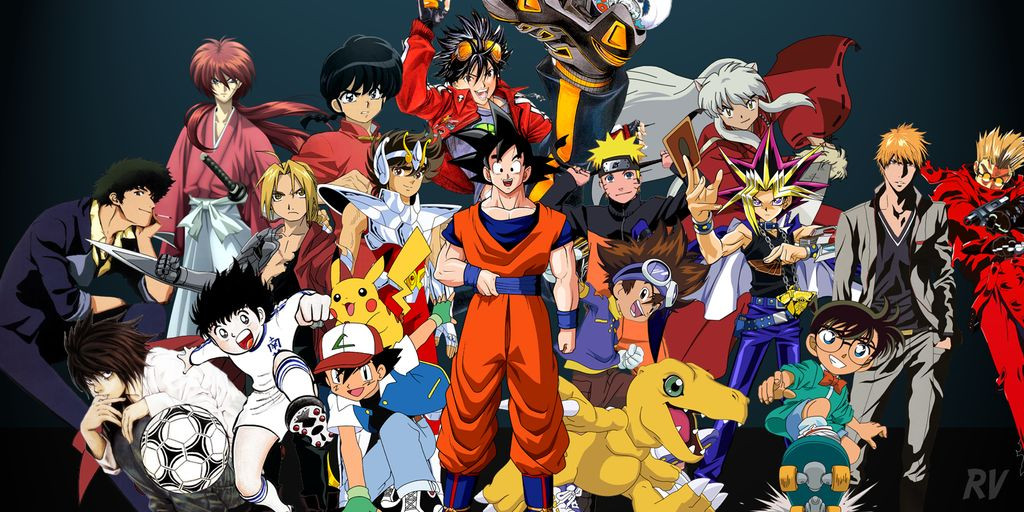